<a href="https://colab.research.google.com/github/Janina712/MLTSA22_JBoecher/blob/main/HW8/HW8_JBoecher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [1]:
# install tensorflow
!pip install tensorflow

     |████████████████████████████████| 462 kB 12.9 MB/s 


In [2]:
!pip install george

     |████████████████████████████████| 407 kB 12.8 MB/s 


In [3]:
# import packages
import tensorflow as tensorflow
from tensorflow import keras

from keras import layers 
from keras.layers import Dense, Input, Flatten,\
                   Reshape, LeakyReLU as LR,\
                   Activation, Dropout
from keras.models import Model, Sequential

from matplotlib import pyplot as plt
from IPython import display
import numpy as np

import os
import json
import pandas as pd
import george
from george import kernels
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize
from sklearn import preprocessing

In [4]:
# mount drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [9]:
# set directory 
%cd /content/gdrive/MyDrive/ColabNotebooks/

/content/gdrive/MyDrive/ColabNotebooks


In [10]:
# import data
df = pd.read_csv("plasticc_train_lightcurves.csv.gz")

In [11]:
df.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


# **2. Define Range of Time Series**

Find maximum mjd value for each time series (object/passband). This is to avoid predicting a large amount of data at the upper edge of the time series, where there are few observed data point informing the prediction. The range of the time series is narrowed in this way. Shift the data by subtrating the min mjd value from the max mjd value for each row.  

In [12]:
# compute mjd min by object and passband
mjd_min = df.groupby(["object_id", "passband"], as_index=False)[["mjd"]].min()

In [13]:
# organize data by object and passband
mjd_max = df.groupby(["object_id", "passband"], as_index=False)[["mjd"]].max()

In [14]:
# initialize new column to store shifted max mjd value
mjd_max['mjd_max_shift'] = 0

In [15]:
# initialize new column to store shifted mjd value
df['mjd_shift'] = 0

In [ ]:
# create a newcolumn in df for the mins that  were calculated across obj and passband
# do one to many mapping
for i in range(0, len(df)):
  for j in range(0, len(mjd_min)):
    if (df.loc[i].object_id == mjd_min.loc[j].object_id) & (df.loc[i].passband == mjd_min.loc[j].passband): 
      df.mjd_shift[i] = mjd_min.mjd[j]

In [ ]:
# create a newcolumn in df for the mins that  were calculated across obj and passband
# do one to many mapping
# interrupted because time-consuming
for i in range(0, len(df)):
  for j in range(0, len(mjd_min)):
    if (df.loc[i].object_id == mjd_min.loc[j].object_id) & (df.loc[i].passband == mjd_min.loc[j].passband): 
      df.mjd_shift[i] = mjd_min.mjd[j]

In [ ]:
# create shorter dataframe below to decrease computational demands

In [39]:
objects = df.object_id.unique()

In [71]:
# do only first object to demonstrate
df_short = pd.DataFrame()

for i in range(0,1):
  df_short = pd.concat([df_short,df.loc[df['object_id'] == objects[i]]])

In [72]:
df_short

,object_id,mjd,passband,flux,flux_err,detected_bool,mjd_shift
0,615,59750.4229,2,-544.810303,3.622952,1,59750
1,615,59750.4306,1,-816.434326,5.553370,1,59750
2,615,59750.4383,3,-471.385529,3.801213,1,59750
3,615,59750.4450,4,-388.984985,11.395031,1,59750
4,615,59752.4070,2,-681.858887,4.041204,1,59750
...,...,...,...,...,...,...,...
347,615,60624.1760,2,552.150269,3.917989,1,798
348,615,60624.1836,1,607.047668,5.140991,1,805
349,615,60624.1913,3,296.946533,3.475000,1,853
350,615,60624.2022,4,235.489929,3.926538,1,853


In [73]:
for i in range(0, len(df_short)):
  for j in range(0, 6):
    if (df_short.loc[i].object_id == mjd_min.loc[j].object_id) & (df_short.loc[i].passband == mjd_min.loc[j].passband): 
      #df_short.mjd_shift[i] = mjd_min.mjd[j]
      df_short.mjd_shift[i] = df_short.mjd[i] - mjd_min.mjd[j]

In [74]:
df_short

,object_id,mjd,passband,flux,flux_err,detected_bool,mjd_shift
0,615,59750.4229,2,-544.810303,3.622952,1,0
1,615,59750.4306,1,-816.434326,5.553370,1,0
2,615,59750.4383,3,-471.385529,3.801213,1,0
3,615,59750.4450,4,-388.984985,11.395031,1,0
4,615,59752.4070,2,-681.858887,4.041204,1,1
...,...,...,...,...,...,...,...
347,615,60624.1760,2,552.150269,3.917989,1,873
348,615,60624.1836,1,607.047668,5.140991,1,873
349,615,60624.1913,3,296.946533,3.475000,1,873
350,615,60624.2022,4,235.489929,3.926538,1,873


In [ ]:
np.savetxt('data_mjd.csv', df, delimiter=',')

In [16]:
# compute shifted mjd value for each row
for i in range(0, len(mjd_max)):
  mjd_max.mjd_max_shift[i]= mjd_max.loc[i].mjd - mjd_min.loc[i].mjd

In [ ]:
# below show only max shifted mjd values

In [17]:
mjd_max.head()

,object_id,passband,mjd,mjd_max_shift
0,615,0,60617.0295,797
1,615,1,60624.1836,873
2,615,2,60624.1760,873
3,615,3,60624.1913,873
4,615,4,60624.2022,873


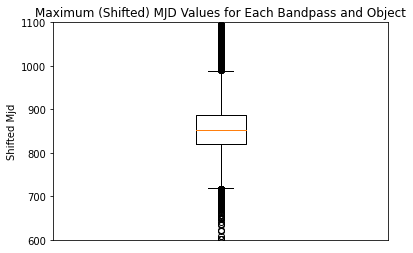

In [18]:
# plot shifted max values
plt.boxplot(mjd_max.mjd_max_shift);
plt.title("Maximum (Shifted) MJD Values for Each Bandpass and Object");
plt.ylabel("Shifted Mjd");
plt.xticks([]);
plt.ylim([600, 1100]);

**Fig. 1.** Maximum shifted mjd values for each bandpass and object. The interquartile range encompasses mjd values between approximately 810 and 890. This means that most time series of the dataset are of this lenght. To prevent predicting a lot of time points past the maximum mjd value, an upper limit will be introduced to limit the range of the data that is being considered for further analysis. 900 is just above the Q3 line and seems to not shorten most of the time series (although there is a appreciable number of ouliers with maximum values > 900). 

# **3. Interpolation Problem**
The time series are irregularly sampled, meaning that the interval between observed data points differs. Since most statistical tools assume evenly spaced data points, interpolation will be employed to inforce measurement regularity upon the time series.

**3a. Generate regular ts as np array**


In [75]:
upper_limit = 900   # upper limit as determined by plot in fig. 1.
N_samples = 100     # N_samples as determined by ???

ts_even = np.linspace(0, upper_limit, N_samples)

**3b. Use Gaussian Processes (GP) to Perform Interpolation**

A. Standardize flux and flux error data and select individual ts to perform interpolation

In [78]:
# standardize 
flux_std = preprocessing.scale(df.flux)
df['flux_std'] = flux_std

flux_err_std = preprocessing.scale(df.flux_err)
df['flux_err_std'] = flux_err_std

In [79]:
df['mjd_shift'] = mjd_max.mjd_max_shift

In [80]:
df

,object_id,mjd,passband,flux,flux_err,detected_bool,mjd_shift,flux_std,flux_err_std
0,615,59750.4229,2,-544.810303,3.622952,1,797.0,-0.154566,-0.005732
1,615,59750.4306,1,-816.434326,5.553370,1,873.0,-0.228287,-0.005226
2,615,59750.4383,3,-471.385529,3.801213,1,873.0,-0.134638,-0.005686
3,615,59750.4450,4,-388.984985,11.395031,1,873.0,-0.112274,-0.003695
4,615,59752.4070,2,-681.858887,4.041204,1,873.0,-0.191762,-0.005623
...,...,...,...,...,...,...,...,...,...
1421700,130779836,60555.9838,4,-39.881969,46.477093,0,NaN,-0.017525,0.005502
1421701,130779836,60560.0459,1,14.894439,18.947685,0,NaN,-0.002658,-0.001715
1421702,130779836,60571.0225,5,30.593130,50.695290,0,NaN,0.001603,0.006608
1421703,130779836,60585.9974,4,-23.471439,44.819859,0,NaN,-0.013071,0.005068


In [81]:
# select single ts from dataset to test interpolation
ts_single = df[(df.object_id==615) & (df.passband == 0)]

In [94]:
ts_single['mjd_indiv'] = df_short.mjd_shift

In [95]:
ts_single

,object_id,mjd,passband,flux,flux_err,detected_bool,mjd_shift,flux_std,flux_err_std,mjd_indiv
54,615,59819.1532,0,6.878784,3.633152,0,854.0,-0.004834,-0.005730,0
55,615,59820.1047,0,39.364853,3.775619,1,845.0,0.003983,-0.005692,0
56,615,59821.1026,0,-10.422381,4.172683,0,845.0,-0.009529,-0.005588,1
57,615,59822.1105,0,-65.485130,4.362876,1,845.0,-0.024474,-0.005538,2
58,615,59823.1505,0,-113.349159,4.069051,1,845.0,-0.037464,-0.005616,3
...,...,...,...,...,...,...,...,...,...,...
337,615,60613.0269,0,-89.973892,2.937887,1,853.0,-0.031120,-0.005912,793
338,615,60614.0276,0,-10.015225,3.212408,0,853.0,-0.009419,-0.005840,794
339,615,60615.0375,0,99.438087,3.662484,1,853.0,0.020288,-0.005722,795
340,615,60616.0290,0,120.849113,3.776495,1,853.0,0.026099,-0.005692,796


In [83]:
# flux values are the measure that we want to predict

In [84]:
y = ts_single.flux_std.values

In [85]:
y

array([-4.83369403e-03,  3.98324931e-03, -9.52934962e-03, -2.44737597e-02,
       -3.74643876e-02, -2.52926831e-02, -3.31229725e-02, -3.31692976e-02,
       -3.61951309e-02, -3.84316991e-02, -3.45928379e-02, -2.09242891e-02,
        8.38081789e-03, -3.57630400e-02, -3.08507431e-02, -2.03196619e-02,
        6.87204656e-03,  2.33586357e-02,  2.61035537e-02,  2.35515168e-02,
       -2.02452760e-02, -3.03566273e-02,  2.04751342e-02,  1.68511629e-02,
        1.55759427e-02,  4.68428302e-03, -4.24124207e-03, -2.92471976e-02,
        2.27424210e-02, -4.86362994e-03, -1.62404142e-02, -2.10642550e-02,
        2.26168782e-02,  2.72748346e-02,  2.25162498e-02,  9.87365111e-03,
       -9.17070060e-03,  2.21898873e-02,  1.15471450e-02,  4.89565742e-05,
       -1.08782788e-02,  1.74737039e-02,  2.55794048e-02,  1.56005691e-02,
        6.83901119e-03, -4.23750290e-03, -1.50504518e-02, -3.42267041e-02,
       -3.67422601e-02, -3.78512200e-02, -2.07090906e-02, -1.17363924e-03,
       -1.33996647e-02, -

B. Define GP Process

In [86]:
# define functions
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [87]:
# define kernel 
kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(0.5), 
                                     kernels.CosineKernel(1))
gp = george.GP(kernel)

In [97]:
x = ts_single.mjd_indiv
yerr = ts_single.flux_err_std

In [98]:
gp.compute(x, yerr)

x_pred = ts_even
pred, pred_var = gp.predict(y, x_pred, return_var=True)

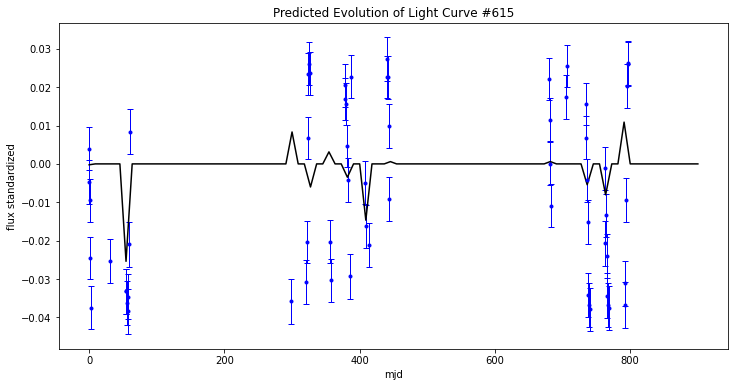

In [103]:
plt.figure(figsize = (12,6))
plt.errorbar(ts_single.mjd_indiv.values , ts_single.flux_std.values, ts_single.flux_err_std.values, fmt='.', color='b', elinewidth=1, capsize=3)
plt.plot(x_pred, pred, 'k');
plt.title("Predicted Evolution of Light Curve #615")
plt.xlabel("mjd")
plt.ylabel("flux standardized");

**Fig. 2.** Gaussian processes were used to interpolate missing data points for evenly spaced x-axis values. The blue datapoints represent the observables, while the back solid line represents the prediction. The upward and downward spikes of the line show the deviation of the observables from zero (standardized). Otherwise, the line is horizontal, which is (maybe?) surprising given that this is GP.

# **4. Save**

To be fed into the autoencoder, the data has to be of shape mjd steps x (#unique object IDs x # passbands). This is done for object #615 below. 

In [113]:
length = 1 * 6

In [115]:
data_structure= np.zeros((length,N_samples))

In [119]:
data_structure.shape

(6, 100)

In [130]:
# each passband
for i in range(0,6):
  ts_single = df[(df.object_id==615) & (df.passband == 0)]
  ts_single['mjd_indiv'] = df_short.mjd_shift
  y = ts_single.flux_std.values

  x = ts_single.mjd_indiv
  yerr = ts_single.flux_err_std
  
  gp.compute(x, yerr)

  x_pred = ts_even
  pred, pred_var = gp.predict(y, x_pred, return_var=True)
  data_structure[i] = pred

In [133]:
data_structure.shape

(6, 100)

In [134]:
np.savetxt('data_615.csv', data_structure, delimiter=',')